<img src="VSM_logo.gif" width="500" align="center">

# Campi Flegrei caldera (Italy) 

## Modelling of 1582 - 1650

**VSM - Volcanic and Seismic source Modelling** is a Python code to perform inversions of geodetic data.

**Code** https://github.com/EliTras/VSM \
**License** E. Trasatti - INGV (elisa.trasatti@ingv.it), covered by GNU-GPL License https://github.com/EliTras/VSM/blob/main/license.lic

This Notebook contains details on the use of VSM to run data inversion, and post-processing

Details of the run
- Analytical forward model: sill-like source, Mogi and Okada
- Sampling algorithm: Neighbourhood Algorithm

### Filename

In [1]:
import os

# path of the working folder
folder_inout = './'
filename_in = 'VSM_input.txt'

## Input data
Input data may be either displacements (m) or velocities (m/yr). If more than an input file is considered, of course the unit must be the same (all displacements or all velocities). For all datapoints, *East* and *North* are the coordinates (metric, preferred system is projected UTM).
Accepted data types are
- InSAR
- GNSS
- Levelling
- EDM
- Tilt
- Strain

### InSAR
This data refers to InSAR data, both single inferterograms or multi-temporal InSAR. Results are typycally in terms of cumulative displacements or annual velocities. The InSAR maps are usually made of thounsands of pixels so it is needed to downsample the dataset first. VSM uses downsampled InSAR datasets.
- up to 10 datasets from different sensors or missions
- a single data file is referred as ` path/sarfile.txt `
- for multiple datasets just leave a blank between fullpath names ` path/sarfile1.txt path/sarfile2.txt `
- accepted formats are comma separated file (.csv), plain text (.txt), ESRI Shapefile (.shp). Ascii files may come with or without header in the first line
- format of columns
       East North Data Error LOS_E LOS_N LOS_Z
       
where *LOS_E*, *LOS_N*, *LOS_Z* are the East, North and vertical components of the versor of the Line of Sight of the sensor.

### GNSS
GNSS data are typically composed of mean velocity for each component of each benchmark.
- the data file is referred to with ` path/gpsfile.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefiles (.shp). Ascii files may come with or without header in the first line
- one row for each station
- format of columns
       East North Data_E Data_N Data_Z Error_E Error_N Error_Z

where *Data_E* is the East component of the displacement or velocity. Same applies to the North (N) and vertical (Z) components and to the error associated.

### Levelling
Levelling data consists of differences of the elevation of benchmarks in a given time window.
- the data file is referred to with ` path/levfile.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefiles (.shp). Ascii files may come with or without header in the first line
- format of columns
       East North Data Error

where *Data* is the different of elevation in the given time period.

### EDM
EDM (Electro-optical Distance Measuring) technique measures the difference in the horizontal position between two points. - the file is referred to with ` path/edmfile.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefiles (.shp). Ascii files may come with or without header in the first line
- format of columns
       East1 North1 East2 North2 Data Error

Each row has the coordinates of the start (1) and end (2) benchmark. *Data* is one single value, that is the change in distance in a given time period.

### Tilt
Tilt is a measure of the displacement-gradient. In particular, it is the inclination of the vertical along a horizontal direction. The horizontal derivatives of the vertical deformation correspond to the East and North components of tilt. 
- the file is referred to with ` path/tiltfile.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefiles (.shp). Ascii files may come with or without header in the first line
- format of columns
       East North Data_E Data_N Error_E Error_N

Each row contains *Data* along East (E) and North (N) directions, and the associated error. If the tiltmeter is not oriented along East or North, data should be projected accordingly. Tilt is adimensional and the unit for VSM is microradians (ppm).

### Strain
Strain is a measure of the displacement-gradient. The volumetric strain is the unit change in volume, i.e. it combines the change of the displacement in the three components. 
- the file is referred to with ` path/strainfile.txt `
- accepted formats are comma separated files (.csv), plain text (.txt), ESRI Shapefiles (.shp). Ascii files may come with or without header in the first line
- format of columns
       East North Data Error

Strain *Data* is adimensional and the unit for VSM is microstrains (ppm).

In [2]:
#Add the input files. By default all file names are 'None'. Set to 'None those unused'

# SAR filename(s)
sar_file = 'None'
#GNSS filename
gps_file = 'None'
# levelling filename
lev_file = '../DATA/1582_1650.csv'
# EDM filename
edm_file = 'None'
#tilt filename
tlt_file = 'None'
# strain filename
srn_file = 'None'

### Weights

In [3]:
# SAR weight
sar_weight = 0.
# GNSS weight
gps_weight = 0.
# levelling weight
lev_weight = 1.
# EDM weight
edm_weight = 0.
# tilt weight
tlt_weight = 0.
# strain weight
srn_weight = 0.

In [4]:
f = open(os.path.join(folder_inout,filename_in), "w")
f.write(folder_inout+'\n')
f.write(sar_file+'\n'+gps_file+'\n'+lev_file+'\n'+edm_file+'\n'+tlt_file+'\n'+srn_file+'\n')
f.write(str(sar_weight)+'\n'+str(gps_weight)+'\n'+str(lev_weight)+'\n'+str(edm_weight)+'\n'+str(tlt_weight)+'\n'+str(srn_weight)+'\n');

### Forward model

In [5]:
import numpy as np

# shear modulus (Pa)
mu = 5e9
# Poisson ratio
ni = 0.25

# number of sources
num_sources = 3

# write this part in the input file
f.write(str(mu)+'\n')
f.write(str(ni)+'\n')
f.write(str(num_sources)+'\n');

### Definition of forward model

#### Mogi Point Source
**Model 0** The Mogi (1958) point source model represents an isotropic point source. Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source source center
- Volume variation

#### Mogi Finite Volume
**Model 1** The McTigue (1987) finite volume model is an evolution of the Mogi model and represents a spherical source with finite volume. Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source center
- Radius of the sphere
- $\Delta P/ \mu$ (Overpressure vs shear modulus ratio)

#### Penny-shaped crack
**Model 2** The penny shaped crack (Fialko et al., 2001) is a disk with a radius and no vertical extension. Parameters:
- East coordinate of the disk center
- North coordinate of the disk center
- Depth of the disk center
- Radius of the disk
- $\Delta P/ \mu$ (Overpressure vs shear modulus ratio)

#### Spheroid
**Model 3** The spheroid (Yang et al., 1988) is a finite-volume cavity with a constant overpressure on the boundary. It can be arbitrarily oriented in space Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source center
- Semi-major axis
- Ratio of semi-minor vs semi-major axes
- $\Delta P/ \mu$ (Overpressure vs shear modulus ratio)
- Strike angle
- Dip angle

#### Ellipsoid
**Model 4** The ellipsoid (Davis, 1986) is a point source defined by its equivalent combination of dipoles and double forces. The P$_{ij}$ matrix must be defined, whose diagonal elements are the dipoles, while the off-diagonal are the double-forces according to catersian coordinates. The results must be interpreted following Davis (1986) tables to find the shape of the ellipsoid and its orientation. Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source center
- P$_{xx}$
- P$_{yy}$
- P$_{zz}$
- P$_{xy}$
- P$_{yz}$
- P$_{zx}$

#### Fault or Dike
**Model 5** The fault model (Okada, 1985) is a rectangular plane undergoing shear slip and/or tensile opening/closing. Two configurations are available. The first uses strike-slip and dip-slip on the fault, while the other uses the total slip and the rake angle. Parameters:
- East coordinate of the top left corner
- North coordinate of the top left corner
- Depth of the top
- Length
- Width
- Strike angle
- Dip angle
- Strike-slip, or, conversely, total slip
- Dip-slip, or, conversely, rake angle
- Tensile movement

In [6]:
# define the source identifier of the forward model
# 0=Mogi 1=McTigue 2=Sill 3=Spheroid 4=Ellipsoid 5=Fault/Dike
# comment or uncomment the lines needed, based on the number of sources employed
sorg_identifier = 2
#parameters minimum and maximum (minimum <= maximum)
param1 = (425750.0, 425750.0)
param2 = (4517900.0, 4517900.0)
param3 = (2000.0, 6000.0)
param4 = (1000.0, 2000.0)
param5 = (-1e-1, -1e-3)
bounds = [param1,param2,param3,param4,param5]

# write file
f.write(str(sorg_identifier)+'\n')
for k in range(len(bounds)):
    row = str(list(bounds[k])[0])+'\t'+str(list(bounds[k])[1])+'\n'
    f.write(row)

# MOGI
sorg_identifier = 0
#parameters minimum and maximum (minimum <= maximum)
param1 = (423200., 423200.)
param2 = (4520750.0, 4520750.0)
param3 = (500.0, 3000.0)
param4 = (-1e8, -1e6)
bounds = [param1,param2,param3,param4]

# write file
f.write(str(sorg_identifier)+'\n')
for k in range(len(bounds)):
    row = str(list(bounds[k])[0])+'\t'+str(list(bounds[k])[1])+'\n'
    f.write(row)

# Deep Layer
sorg_identifier = 5
#parameters minimum and maximum (minimum <= maximum)
param1 = (421000.0, 421000.0)
param2 = (4524000.0, 4524000.0)
param3 = (8000.0, 8000.0)
param4 = (10000.0, 10000.0)
param5 = (10000.0, 10000.0)
param6 = (89.99, 89.99)
param7 = (0.001, 0.001)
param8 = (0.0, 0.0)
param9 = (0.0, 0.0)
param10 = (-2., 10.)
okada_mode = 'R'

bounds = [param1,param2,param3,param4,param5,param6,param7,param8,param9,param10]

# write this part in the input file
if(sorg_identifier!= 5):
    f.write(str(sorg_identifier)+'\n')
else:
    f.write(str(sorg_identifier)+' '+okada_mode+'\n')
       
for k in range(len(bounds)):
    row = str(list(bounds[k])[0])+'\t'+str(list(bounds[k])[1])+'\n'
    f.write(row)

## VSM settings

### Inversion algorithms
There are two inversion tools included in VSM
- **NA** is the **Neighbourhood Algorithm**, a global optimizer based on the Voronoi cells theory for the sampling (Sambridge, 1999). The parameters needed are:
    - number of samples at each iteration `sampl1`
    - number of re-samples from each iteration `sampl2`
    - number of iterations `sampl3`
- **BI** is the **Bayesian Inference**, an inversion tool based on the Bayes theory and MCMC sampling. The parameters needed are:
    - number of random walks `sampl1`
    - number of steps for each random walk `sampl2`

In [7]:
# inversion choice NA = 0 BI = 1
inversion_choice = 0
# accordingly define the sampling parameters
sampl1 = 2000
sampl2 = 700
sampl3 = 35

f.write(str(inversion_choice)+'\n')
if(inversion_choice == 0):
    f.write(str(sampl1)+' '+str(sampl2)+'\n')
    f.write(str(sampl3)+'\n')
else:
    f.write(str(sampl1)+'\n')
    f.write(str(sampl2)+'\n')

### Plots

In [8]:
# Number of burn-in models. Default is 2000. No plots for -1
num_skip = 2000
f.write(str(num_skip)+'\n');

In [9]:
# END of settings for the VSM input!
f.close()

## Launch VSM

In [10]:
import os
import sys
sys.path.append('../../../../PYTHON/VSM')

import VSM

In [11]:
# Read VSM input
VSM.read_VSM_settings(os.path.join(folder_inout,filename_in))



*******************************************************************************

                   VSM exectution begins

Start reading settings of VSM from input file -->
./VSM_input.txt 

Data -->
InSAR data file # 1 None
Levelling data file ../DATA/1582_1650.csv

Source 1 considered -->
 Penny-shaped crack (Fialko et al., 2001)

Source 2 considered -->
 Mogi Point Source (Mogi, 1958)

Source 3 considered -->
 Rectangular Dislocation (Okada, 1985) with mode R

There are 19 total free parameters
Parameters actually inverted -->  6
depth (2000.0, 6000.0)
radius (1000.0, 2000.0)
dP_mu (-0.1, -0.001)
depth_2 (500.0, 3000.0)
dVol_2 (-100000000.0, -1000000.0)
opening_3 (-2.0, 10.0)

Inversion tool chosen --> NEIGHBOURHOOD ALGORITHM
N. of samples:  2000 N. of re-samples 700
N. of iterations:  35

Number of burn-in samples for the plots --> 2000 





Reading data...
Found  18 Levelling data

Output folder is -->
 ./

                    All input read

*******************************************************************************

NEIGHBOURHOOD ALGORITHM running...
Searcher(iteration=1, samples=2000, best=1.133929e-01)
Searcher(iteration=2, samples=4000, best=1.075473e-01)
Searcher(iteration=3, samples=6000, best=1.044162e-01)
Searcher(iteration=4, samples=8000, best=1.044162e-01)
Searcher(iteration=5, samples=10000, best=1.014685e-01)
Searcher(iteration=6, samples=12000, best=9.934260e-02)
Searcher(iteration=7, samples=14000, best=9.934260e-02)
Searcher(iteration=8, samples=16000, best=9.905710e-02)
Searcher(iteration=9, samples=18000, best=9.905710e-02)
Searcher(iteration=10, samples=20000, best=9.855341e-02)
Searcher(iteration=11, samples=22000, best=9.848209e-02)
Searcher(iteration=12, samples=24000, best=9.821825e-02)
Searcher(iteration=13, samples=26000, best=9.819700e-02)
Searcher(iteration=14, samples=28000, best=9.807902

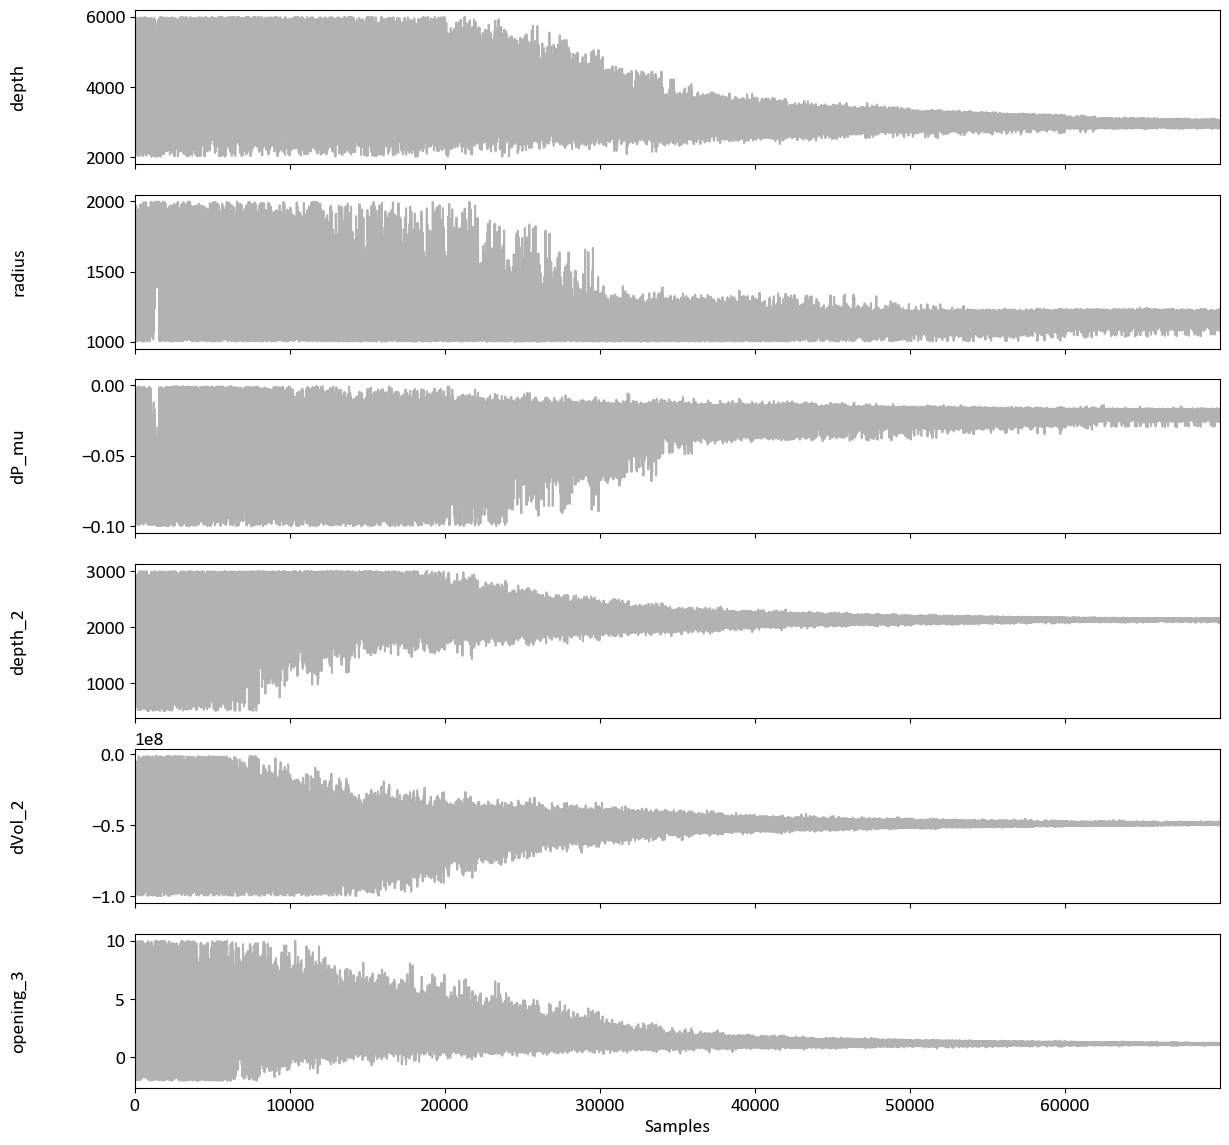

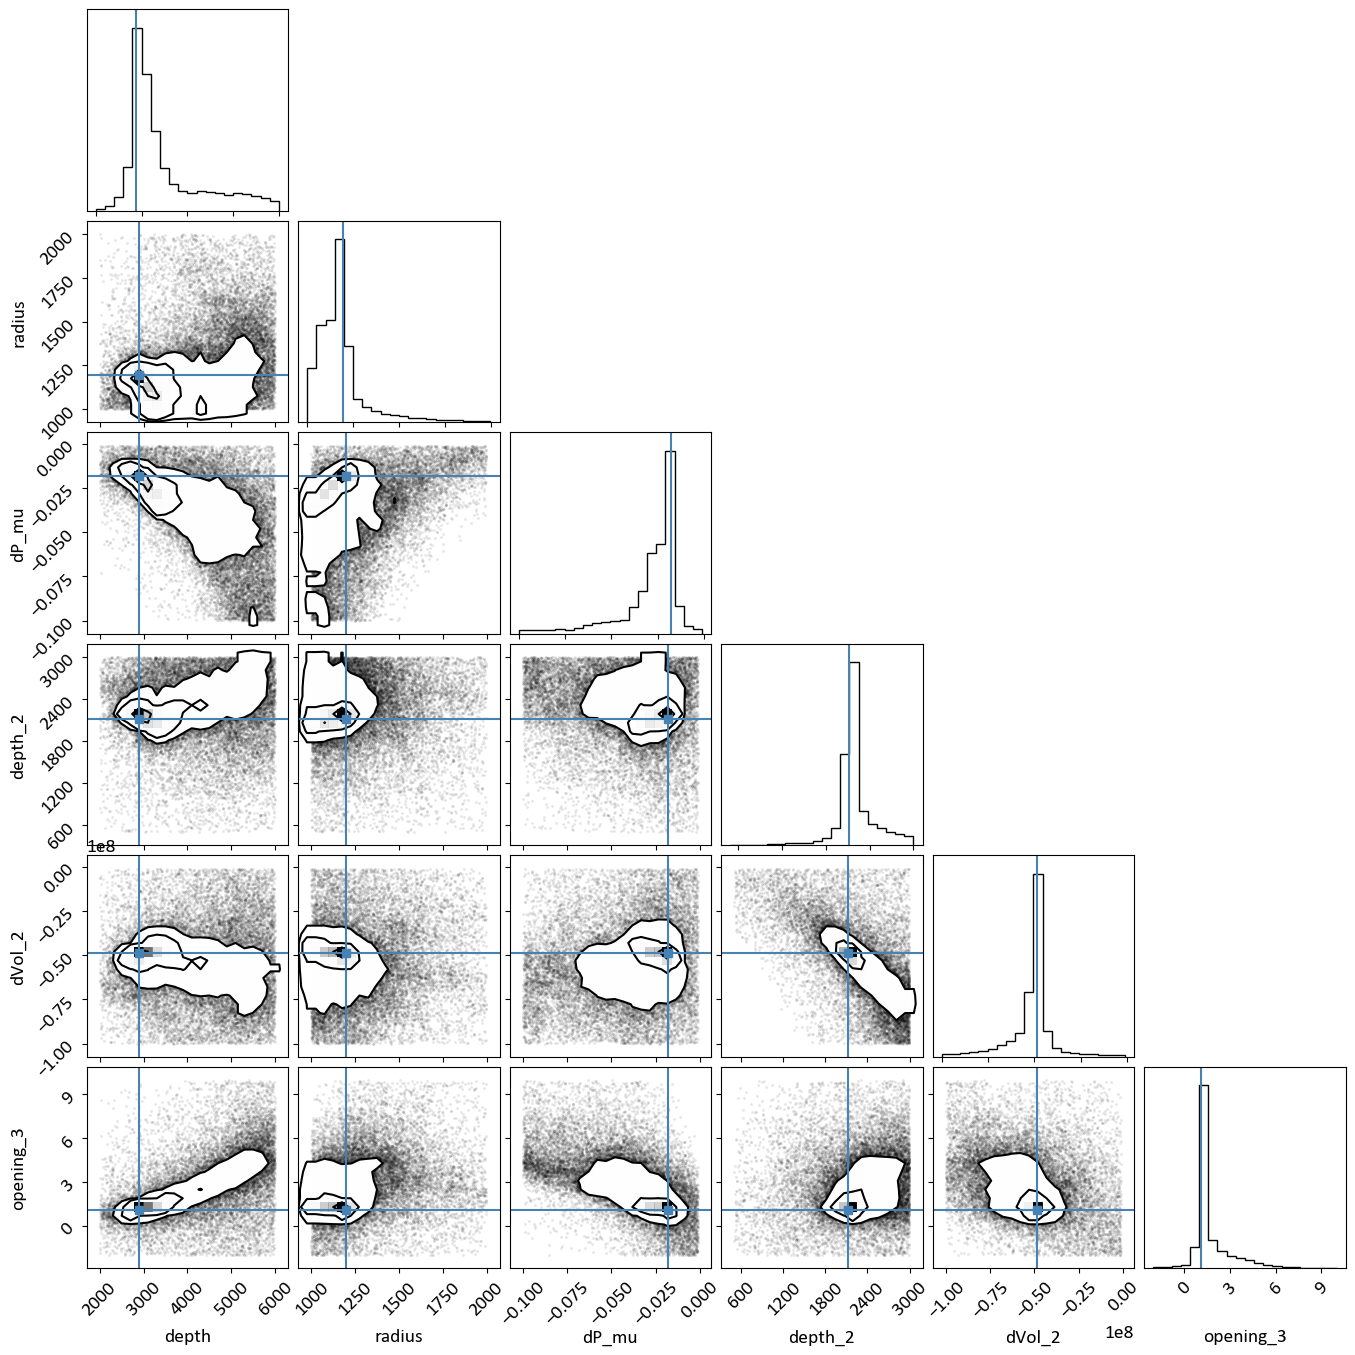

In [12]:
# Run VSM
VSM.iVSM()

## Post Processing

In [13]:
import VSM_utilities as VSMU
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Plot Data, model and residuals

In [14]:
synth_file = 'VSM_synth_lev.csv'
out_file = 'VSM_res_lev.png'

# UTM zone
zone = 33
southern_hemisphere = False

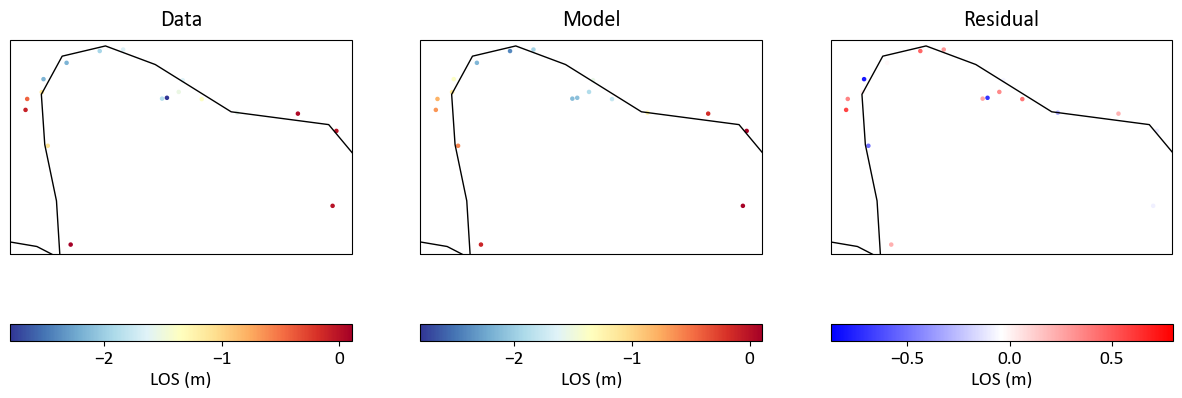

In [15]:
# My data in UTM coordinates
db_sar = pd.read_csv(folder_inout+'/'+synth_file)
d_sar = db_sar.values

# Split into east and north coordinates
east, north = d_sar[:,0],d_sar[:,1]
data = d_sar[:,3]
synth = d_sar[:,2]
res = data - synth

dmax = max(max(data),max(synth))
dmin = min(min(data),min(synth))
resmax = max(res)
resmin = min(res)
resext = max(resmax, -resmin)

# Define the projection
#crs=ccrs.PlateCarree()
mycrs=ccrs.UTM(zone=zone, southern_hemisphere=southern_hemisphere)

fig=plt.figure(figsize=(15,6))

## PANEL DATA ##########
ax = plt.subplot(131, projection=mycrs)
ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, data, cmap="RdYlBu_r", vmin=dmin, vmax = dmax)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
plt.title('Data',fontsize = 16, pad=10)

## PANEL MODEL ##########
ax = plt.subplot(132, projection=mycrs)
ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, synth,cmap="RdYlBu_r", vmin=dmin, vmax = dmax)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
plt.title('Model',fontsize = 16, pad=10)

## PANEL RESIDUALS ##########
ax = plt.subplot(133, projection=mycrs)
ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, data - synth,cmap="bwr",vmin=resext, vmax = -resext)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
# Title for plot
plt.title('Residual',fontsize = 16, pad=10)

plt.savefig(folder_inout+'/'+out_file)
plt.show()

### Sill volume variation

In [16]:
db_best = pd.read_csv(os.path.join(folder_inout,'VSM_best.csv'))
d_best = db_best.values

r = d_best[0,1]
dpmu = d_best[0,2]
ni = 0.25
dVol = VSMU.volume_var_penny(dpmu,r,ni)
dVol/1e9

-0.06145523873435877

In [20]:
r = 1200
dpmu = -0.018
ni = 0.25
dVol = VSMU.volume_var_penny(dpmu,r,ni)
dVol/1e9

-0.06220799999999999